
## Проект 5. Компьютер говорит «Нет» 
### Целиков Сергей

### 1. Импортируем библиотеки

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import Series


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path_files = '/kaggle/input/sf-dst-scoring/'


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# визуализируем числовые признаки
def visualize(data, col, size = 6):
    fig, ax = plt.subplots(2, 2, figsize = (2*size,2*size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    ax[0,0].hist(data[col], bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    ax[0,1].boxplot(data[col], vert = False)  
    ax[1,0].hist(np.log(data[col] +1), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    ax[1,1].boxplot(np.log(data[col] +1), vert = False)  # выбросы
    ax[1,0].set(title = 'log (' + col + ')')
    ax[1,1].set(title = 'log (' + col + ')')
    ax[0,0].set(title = col)
    ax[0,1].set(title = col)
    plt.figtext(0.5, 0, col, fontsize = 16)
    plt.show()
    

    
# Поиск выбросов
def outliers(col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(data[data[col] > r][col].count() + data[data[col] < l][col].count()))
    print('Медиана:', median)
    print('Среднее:', data[col].mean())
    print('Среднеквадратичное отклонение:', data[col].std())
    
    
#Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index = metrics)
def summary_metrics(summary,col,y_test,y_predicted,y_pred_probs):
    values = [accuracy_score(y_test,y_predicted), precision_score(y_test,y_predicted), recall_score(y_test,y_predicted), f1_score(y_test,y_predicted), roc_auc_score(y_test, y_pred_probs)]
    summary[col] = values
    return summary


# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


# Confusion matrix
def conf_mat(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')

### Импорт и просмотр данных

In [3]:

data_train = pd.read_csv(path_files +'train.csv')
data_test = pd.read_csv(path_files +'test.csv')
sample_submission = pd.read_csv(path_files +'sample_submission.csv')

print('data_train: ', data_train.shape)
display(data_train.head(5))
print('data_test: ', data_test.shape)
display(data_test.head(5))
print('sample_submission: ', sample_submission.shape)
display(sample_submission.head(5))

data_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


data_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


sample_submission:  (24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


### Объединение датасететов для того, чтобы корректно обработать признаки

In [4]:
data_train['train'] = 1 # помечаем train data
data_test['train'] = 0 # помечаем test data
data_test['default'] = 0 # в test data у нас нет значения default, пока просто заполняем нулями

data = pd.concat([data_train, data_test], sort=False).reset_index(drop=True) # объединяем

### Предварительный анализ данных

### Описание признаков

* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
#  Посмотрим наличие пропусков в данных
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

In [7]:
#Пропуски есть только в столбце education
#Посмотрим, какую часть от датасета они составляют.

print('Пропуски составляют {} % позиций'.format(data['education'].isnull().sum()/len(data.education)*100))



Пропуски составляют 0.4339615789664814 % позиций


In [8]:
#Поскольку пропусков немного, заменим их на наиболее часто встречающееся значение.
data['education'] = data['education'].fillna(data['education'].mode()[0])

### Посмотрим на дату подачи заявки (app_date)

In [9]:
# преобразуем дату подачи заявки в формат даты

from datetime import datetime
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

<AxesSubplot:xlabel='app_date', ylabel='default'>

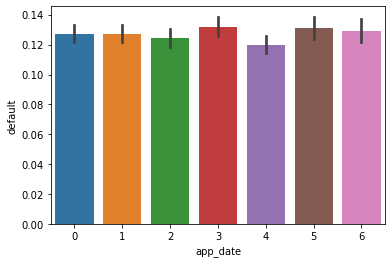

In [10]:
# посмотрим на распределение default относительно дня недели
sns.barplot(data=data[data['train']==1], x=data.loc[data['train']==1,'app_date'].dt.weekday, y='default')

<AxesSubplot:xlabel='app_date', ylabel='default'>

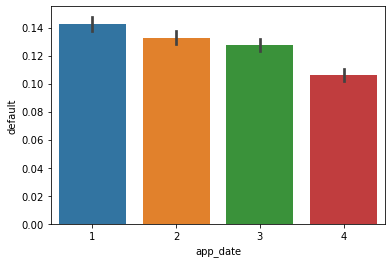

In [11]:
# от дня недели default не зависит 
# посмотрим на месяц
sns.barplot(data=data[data['train']==1], x=data.loc[data['train']==1,'app_date'].dt.month, y='default')

Text(0, 0.5, 'Number of Applications')

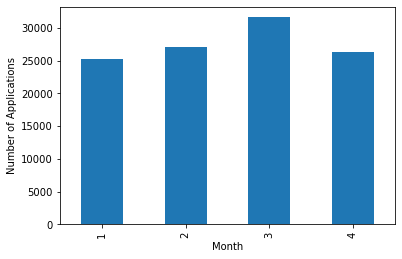

In [12]:
# посмотрим количество поданных заявок по месяцам
data['app_date'].dt.month.value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Applications')

In [13]:
# Зависимость от месяца присутствует, попробуем использовать этот признак
# добавим новый признак app_month
data['app_month'] = data['app_date'].dt.month
# Сам признак app_data удалим, он нам больше не понадобится:
data = data.drop('app_date', axis=1)

In [14]:
# в датасете есть 1 признак - дата, 5 бинарных признаков (default - целевая переменная, исключаем ее), 5 категориальных и 5 числовых. 
# client_id исключили из списка

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_month']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income'] 

## Исследуем числовые признаки

## age

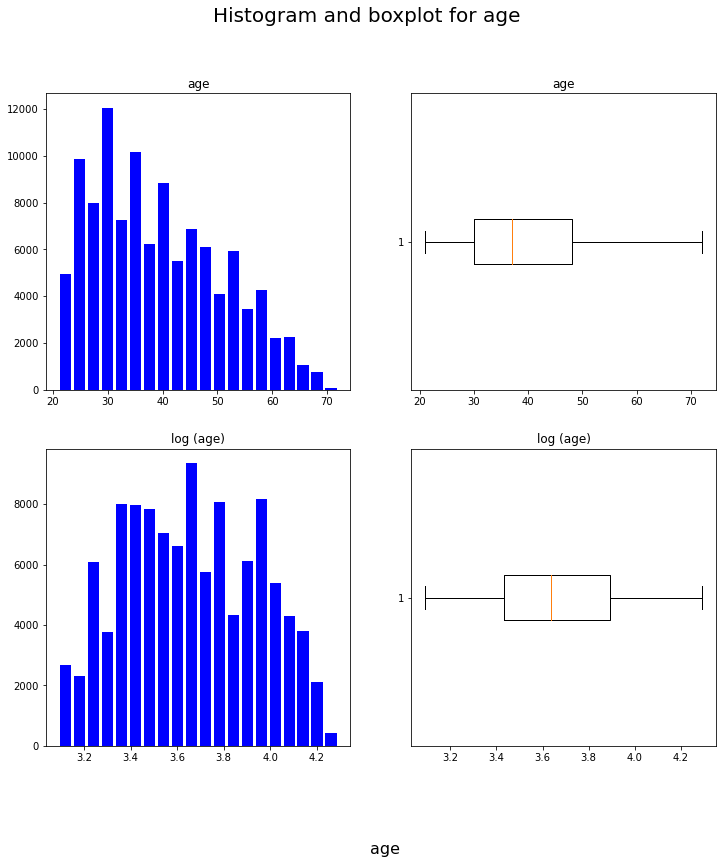

In [15]:
visualize(data, 'age')

In [16]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.
data['age'] = np.log(data['age'] + 1)

### decline_app_cnt

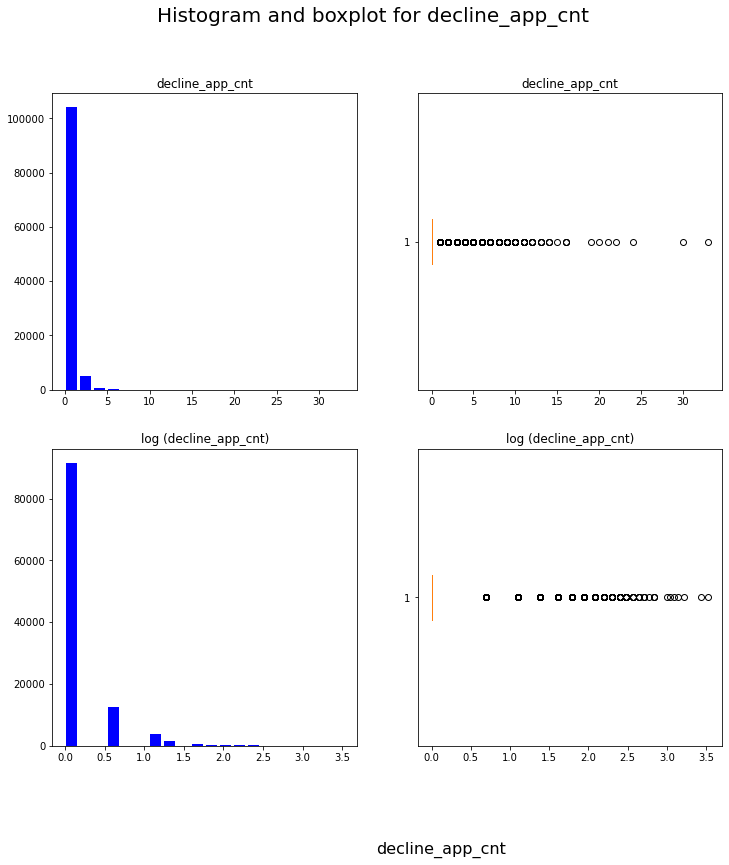

In [17]:
visualize(data, 'decline_app_cnt')

In [18]:
# Распределение непонятно, исследуем дальше
data['decline_app_cnt'].value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
30    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

In [19]:
# В 83% выборки - значение 0. У большей части отказов раньше не было. 

# Посмотрим распределение тех, у кого были отказы

data[data['decline_app_cnt'] > 0]['decline_app_cnt'].value_counts(normalize=True)

1     0.669272
2     0.193928
3     0.073085
4     0.032446
5     0.013653
6     0.008353
7     0.003105
8     0.001981
9     0.001553
10    0.000857
11    0.000535
12    0.000268
13    0.000214
16    0.000161
14    0.000161
30    0.000054
22    0.000054
24    0.000054
21    0.000054
20    0.000054
19    0.000054
33    0.000054
15    0.000054
Name: decline_app_cnt, dtype: float64

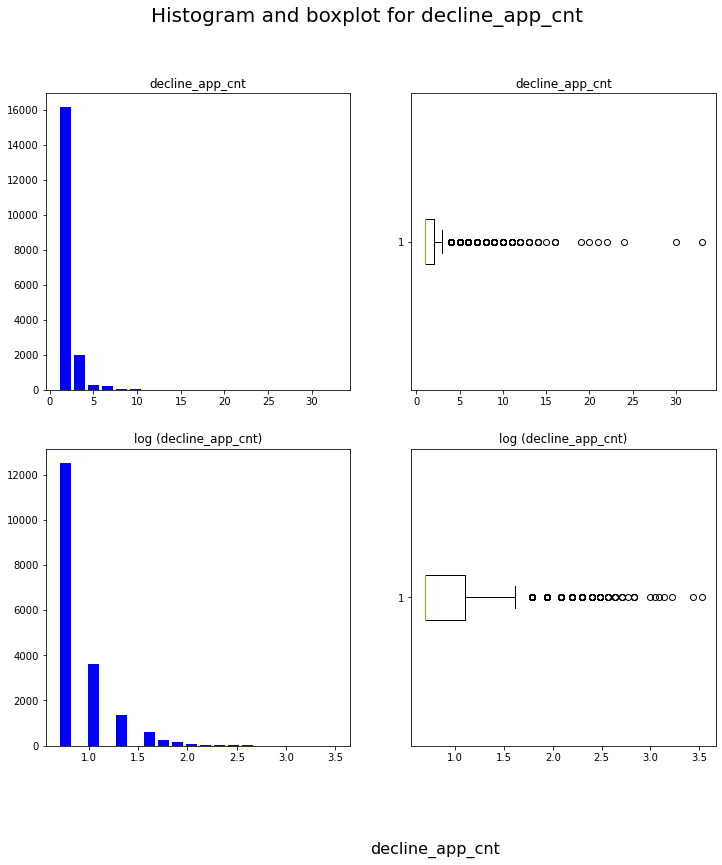

In [20]:
visualize(data[data['decline_app_cnt'] > 0], 'decline_app_cnt')

In [21]:
# клиенты с количеством отказов больше 5 составляют менее 1% от общего количества
# Можем перенести этот признак в разряд категориальных, сделав следующую категоризацию:
# оставляем количество отказов от 0 до 3, всем остальным присваиваем 4
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: 4 if x > 3 else x)

In [22]:
data['decline_app_cnt'].value_counts(normalize=True)

0    0.830437
1    0.113484
2    0.032883
3    0.012392
4    0.010804
Name: decline_app_cnt, dtype: float64

In [23]:
# переносим колонку в разряд категориальных
cat_cols.append('decline_app_cnt')
num_cols.remove('decline_app_cnt')

In [24]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_month',
 'decline_app_cnt']

## score_bki

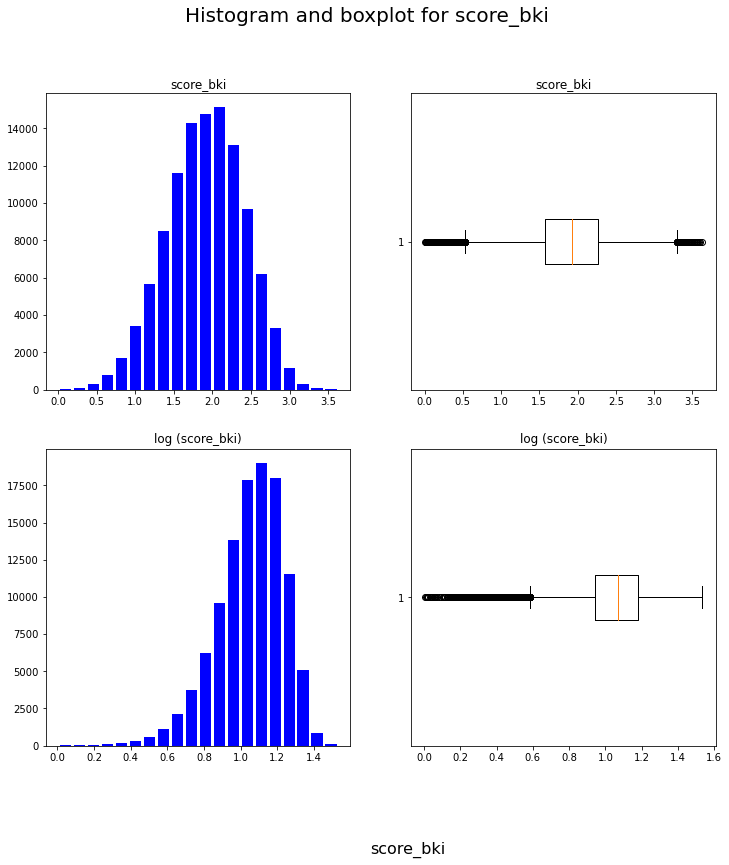

In [25]:
visualize(data[['score_bki']].abs(), 'score_bki')

In [26]:
outliers('score_bki')

Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов
Медиана: -1.92082293
Среднее: -1.904535048828952
Среднеквадратичное отклонение: 0.49939749240506476


In [27]:
#Распределение похоже на нормальное, оставляем как есть, логарифмировать не будем

### bki_request_cnt

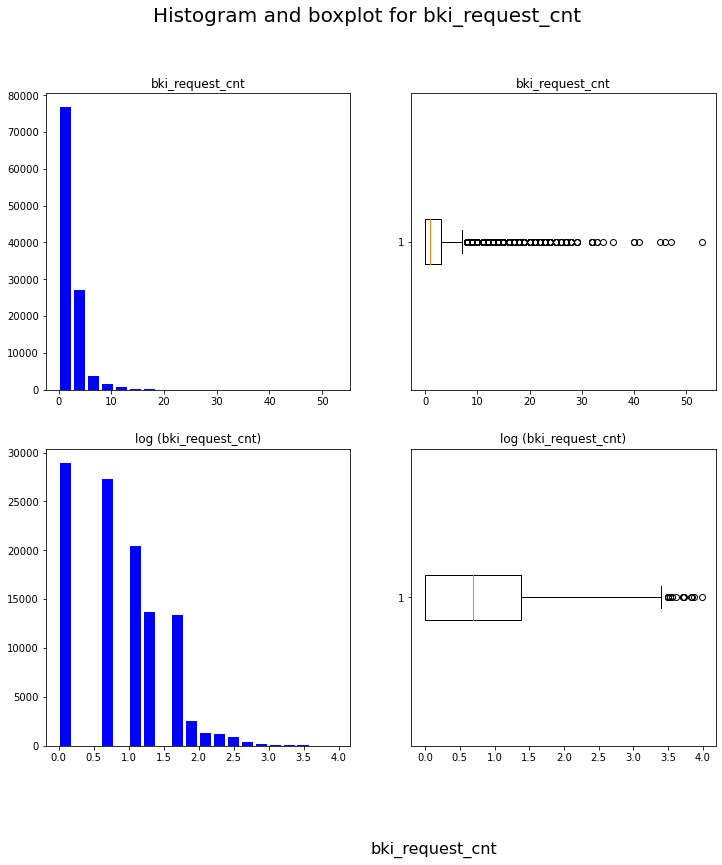

In [28]:
visualize(data, 'bki_request_cnt')

In [29]:
outliers('bki_request_cnt')

Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Медиана: 1.0
Среднее: 2.0050023604604714
Среднеквадратичное отклонение: 2.2669258672263157


In [30]:
data['bki_request_cnt'].value_counts(normalize=True)

0     0.262447
1     0.247803
2     0.185941
3     0.124106
4     0.076316
5     0.045030
6     0.022697
7     0.011730
8     0.006673
9     0.004167
10    0.003178
11    0.002524
12    0.001970
13    0.001371
14    0.000999
15    0.000735
16    0.000527
17    0.000300
18    0.000291
19    0.000272
21    0.000172
20    0.000127
24    0.000109
23    0.000109
22    0.000073
25    0.000045
27    0.000045
28    0.000045
26    0.000036
32    0.000036
29    0.000027
40    0.000018
33    0.000018
36    0.000009
34    0.000009
41    0.000009
45    0.000009
46    0.000009
47    0.000009
53    0.000009
Name: bki_request_cnt, dtype: float64

In [31]:
# Вывод - возьмем логарифм от признака.
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

### income

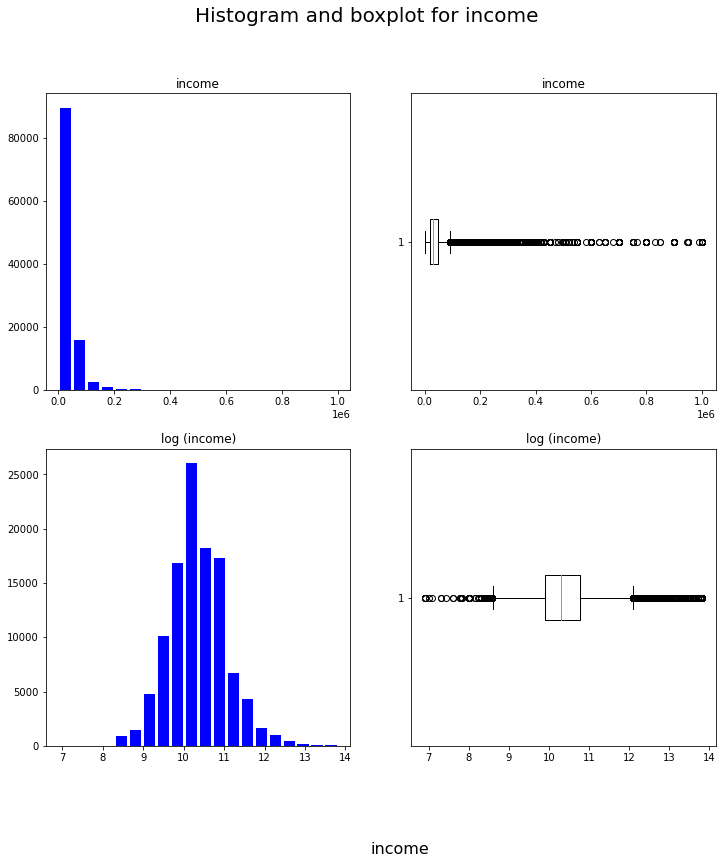

In [32]:
visualize(data, 'income')

In [33]:
outliers('income')

Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Медиана: 30000.0
Среднее: 41012.648536514505
Среднеквадратичное отклонение: 45399.73505142421


In [34]:
# Распределение логнормальное - возьмем логарифм от признака.
data['income'] = np.log(data['income'] + 1)

<AxesSubplot:>

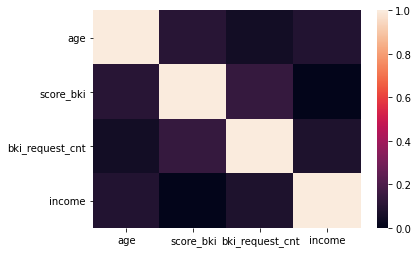

In [35]:
#Оценим корреляцию Пирсона для непрерывных переменных
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

<AxesSubplot:>

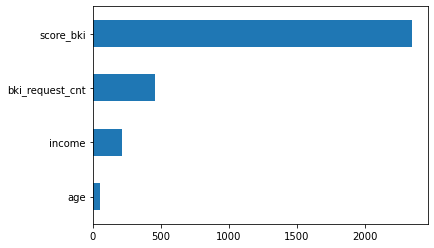

In [36]:
# сильной корреляции признаков нет.

#Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

imp_num = Series(f_classif(data[data['train']==1][num_cols], data[data['train']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Исследуем категориальные признаки

In [37]:
display(cat_cols)

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_month',
 'decline_app_cnt']

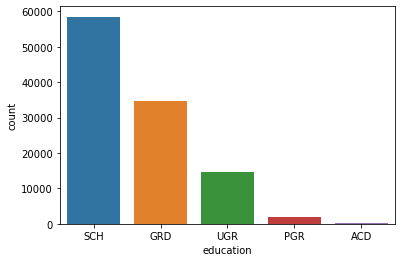

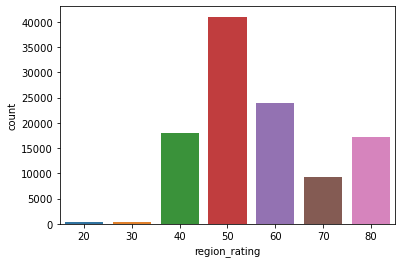

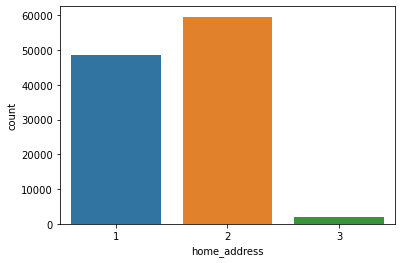

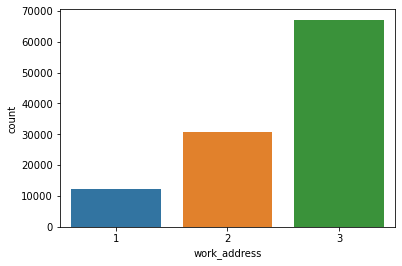

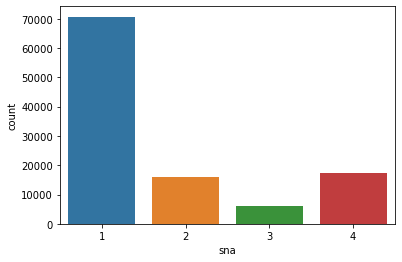

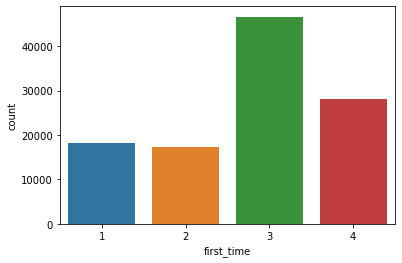

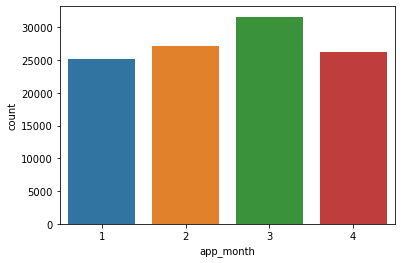

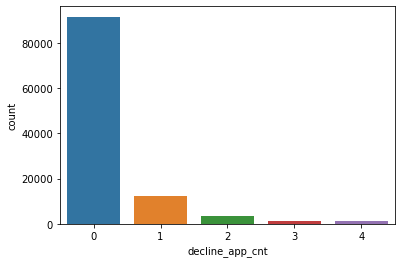

In [38]:
# визуализируем категориальные признаки:
for col in cat_cols:
    sns.countplot(x=data[col])
    plt.show()

In [39]:
# заменяем строковые значения в столбце education на числовые

encoder = LabelEncoder()
encoder.fit(data['education'])
data['education'] = encoder.transform(data['education'])

### Исследуем бинарные признаки

In [40]:
display(bin_cols)

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

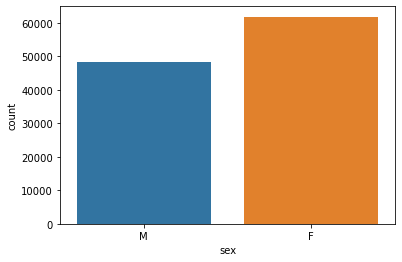

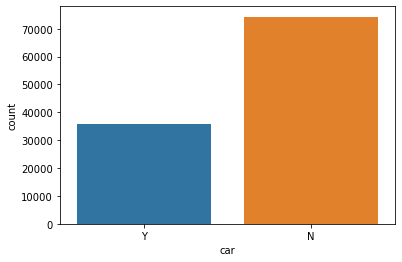

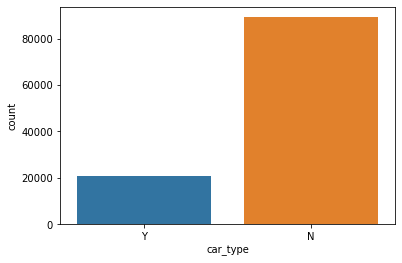

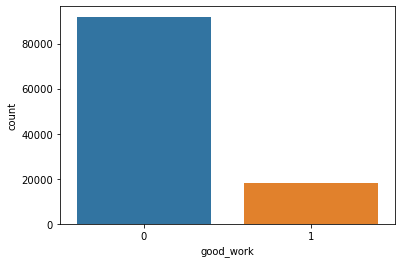

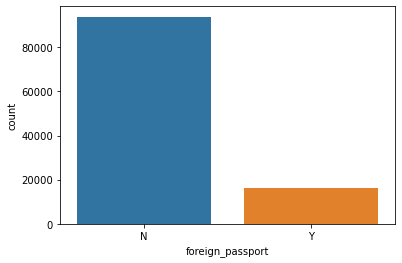

In [41]:
# визуализируем бинарные признаки:
for col in bin_cols:
    sns.countplot(x=data[col])
    plt.show()

In [42]:
# перекодируем бинарные признаки
lbl_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = lbl_encoder.fit_transform(data[column])
    

In [43]:
# проверим результат
data.head(10)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,app_month
0,25905,3,1,4.143135,1,1,0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,1,2
1,63161,3,0,4.094345,0,0,0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,1,3
2,25887,3,1,3.258097,1,0,2,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,1,2
3,16222,3,0,3.988984,0,0,0,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,1,1
4,101655,1,1,3.891820,0,0,0,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,1,4
5,41415,3,1,3.332205,1,0,0,1,-2.032257,0.000000,50,1,1,9.615872,2,3,0,0,1,2
6,28436,3,1,3.688879,0,0,0,0,-2.225004,0.000000,60,1,2,10.239996,1,1,0,0,1,2
7,68769,3,0,3.688879,0,0,0,0,-1.522739,0.693147,50,2,3,10.714440,3,3,0,0,1,3
8,38424,3,0,3.931826,1,0,1,0,-1.676061,0.000000,50,1,1,10.308986,1,4,0,0,1,2
9,4496,4,0,4.007333,0,0,0,0,-2.695176,0.693147,50,2,3,10.085851,1,3,0,0,1,1


<AxesSubplot:>

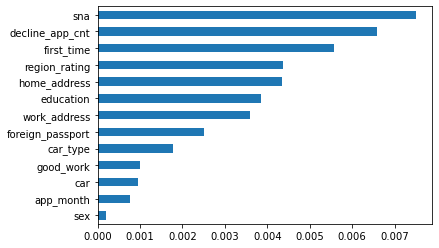

In [44]:
# проверим значимость бинарных и категориальных признаков
imp_cat = Series(mutual_info_classif(data[data['train']==1][bin_cols + cat_cols], data[data['train']==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

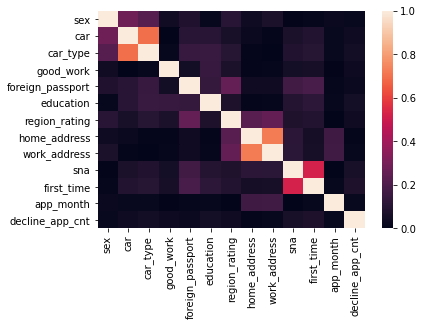

In [45]:
# Оценим взаимную корреляцию бинарных и категориальных признаков
sns.heatmap(data[bin_cols + cat_cols].corr().abs(), vmin=0, vmax=1)

In [46]:
# Следующие признаки имеют очень высокую корреляцию:
#  car и car_type
#  home_address и work_address
#  sna и first_time

data[['car','car_type', 'home_address', 'work_address', 'sna', 'first_time']].corr()

,car,car_type,home_address,work_address,sna,first_time
car,1.000000,0.698760,-0.024142,-0.008410,-0.074095,0.090976
car_type,0.698760,1.000000,-0.011276,0.001170,-0.087095,0.102278
home_address,-0.024142,-0.011276,1.000000,0.726535,0.114541,-0.058430
work_address,-0.008410,0.001170,0.726535,1.000000,0.111162,-0.062266
sna,-0.074095,-0.087095,0.114541,0.111162,1.000000,-0.526594
first_time,0.090976,0.102278,-0.058430,-0.062266,-0.526594,1.000000


## Возможно, что признаки first_time, work_address, car следует удалить

In [47]:
# заменим все категориальные признаки на dummi переменные

data = pd.get_dummies(data, columns=cat_cols)

In [48]:
# Проверим результат
data.head()

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,first_time_4,app_month_1,app_month_2,app_month_3,app_month_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4
0,25905,1,4.143135,1,1,0,-2.008753,0.693147,9.798183,0,...,0,0,1,0,0,1,0,0,0,0
1,63161,0,4.094345,0,0,0,-1.532276,1.386294,9.852247,0,...,0,0,0,1,0,1,0,0,0,0
2,25887,1,3.258097,1,0,0,-1.408142,0.693147,10.308986,1,...,1,0,1,0,0,0,0,1,0,0
3,16222,0,3.988984,0,0,0,-2.057471,1.098612,9.210440,0,...,0,1,0,0,0,1,0,0,0,0
4,101655,1,3.891820,0,0,1,-1.244723,0.693147,10.308986,1,...,1,0,0,0,1,1,0,0,0,0


In [49]:
# удалим столбец client_id, т.к. это порядковый номер клиента
# анализ его влияния на другие параметры не проводился
data = data.drop('client_id', axis=1)

## Поcтроим базовую модель

In [50]:
# разделяем наш объединенный ранее датасет на первоначальные части - train_df и test_df

train_dfm = data[data['train']== 1].drop(['train'], axis=1)
test_dfm = data[data['train']== 0].drop(['train'], axis=1)

In [51]:
X = train_dfm.drop(['default'], axis=1).values
y = train_dfm['default'].values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Обучаем модель на стандартных настройках логистической регрессии.

In [53]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)


probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]

y_predicted = model.predict(X_test)

print('accuracy score:', accuracy_score(y_test,y_predicted))
print('precision score:', precision_score(y_test,y_predicted))
print('recall score:',recall_score(y_test,y_predicted))
print('f1 score:',f1_score(y_test,y_predicted))
print('ROC AUC score:',roc_auc_score(y_test, y_pred_probs))

accuracy score: 0.8746612466124661
precision score: 0.3925233644859813
recall score: 0.022988505747126436
f1 score: 0.043433298862461216
ROC AUC score: 0.7445259854893591


In [54]:
# посмотрим метрики
summary_metrics(summary,'Model 1',y_test,y_predicted,y_pred_probs)

,model 1
accuracy,0.874661
precision,0.392523
recall,0.022989
f1_score,0.043433
ROC_AUC,0.744526


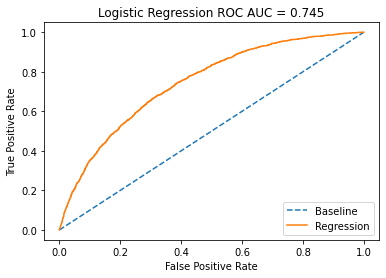

In [55]:
# построим график ROC AUC
roc_auc_curve(y_test, y_pred_probs)

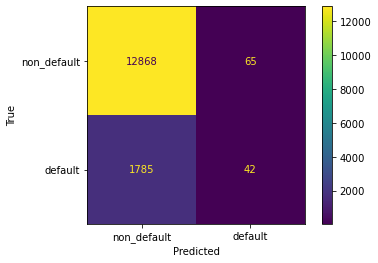

In [56]:
# построим confusion matrix
conf_mat(y_test, y_predicted)

## Попробуем улучшить модель.
### Найдем оптимальное значение параметра регуляризации для логистической регрессии.
### рассмотрим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией.

In [57]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
#penalty = ['l1', 'l2']
penalty = [ 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter = 500)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 21.544346900318832


### Используем новые значения

In [58]:
model = LogisticRegression(max_iter = 1000, penalty = 'l2', C = 21)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_predicted = model.predict(X_test)


In [59]:
# посмотрим метрики
summary_metrics(summary,'Model 2',y_test,y_predicted,y_pred_probs)

,model 1,model 2
accuracy,0.874661,0.874593
precision,0.392523,0.388889
recall,0.022989,0.022989
f1_score,0.043433,0.043411
ROC_AUC,0.744526,0.744489


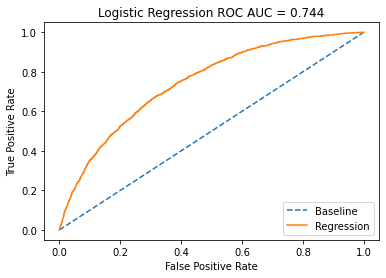

In [60]:
# построим график ROC AUC
roc_auc_curve(y_test, y_pred_probs)

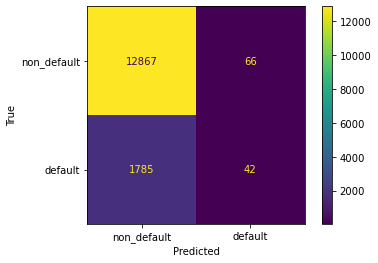

In [61]:
# построим confusion matrix
conf_mat(y_test, y_predicted)

## Улучшений модели нет
### используем GridSearchCV для поиска наилучших параметров

In [62]:
model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34119519        nan
 0.34119519        nan 0.05619353 0.0562013         nan 0.05619353
 0.05619353 0.05619353 0.0562013         nan 0.05619353 0.05619353
 0.34119625 0.34144513 0.3413633  0.34130677 0.34129532 0.34119625
 0.34144513 0.3413633  0.34130677 0.34129532 0.05641919 0.05643398
 0.05641919 0.05641919 0.05641919 0.05643398 0.05641919 0.05641919
 0.34124001 0.34132483 0.34128716 0.34124001 0.34124001 0.34132483
 0.34128716 0.34124001]
  category=UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the 

In [73]:
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print('  %s = %r' % (param_name, best_parameters[param_name]))

Лучшие значения параметров:
  C = 1.0
  class_weight = 'balanced'
  dual = False
  fit_intercept = True
  intercept_scaling = 1
  l1_ratio = None
  max_iter = 100
  multi_class = 'auto'
  n_jobs = None
  penalty = 'l2'
  random_state = 42
  solver = 'lbfgs'
  tol = 0.0001
  verbose = 0
  warm_start = False


In [64]:
model = LogisticRegression(C = 1.0,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 200,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'lbfgs',
  tol = 0.0001,
  verbose = 0,
  warm_start = False)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_predicted = model.predict(X_test)

In [65]:
# посмотрим метрики
summary_metrics(summary,'Model 3',y_test,y_predicted,y_pred_probs)

,model 1,model 2,model 3
accuracy,0.874661,0.874593,0.671206
precision,0.392523,0.388889,0.226401
recall,0.022989,0.022989,0.685276
f1_score,0.043433,0.043411,0.340356
ROC_AUC,0.744526,0.744489,0.744208


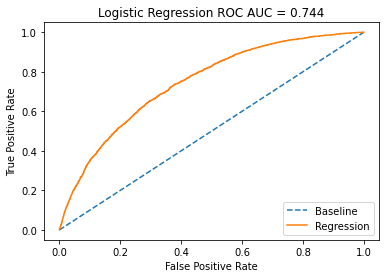

In [66]:
# построим график ROC AUC
roc_auc_curve(y_test, y_pred_probs)

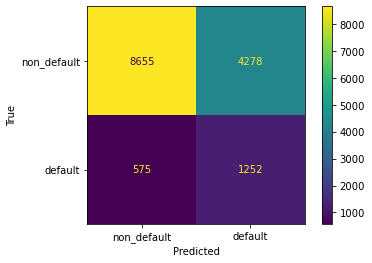

In [67]:
# построим confusion matrix
conf_mat(y_test, y_predicted)

### модель сохранила показатели ROC AUC, но приэтом ее поведение кардинально изменилось
### она стала более строгой, то есть стала угадывать большинство плохих клиентов, но при этом отказывать многим хорошим клиентам.

### Попробуем использовать LogisticRegressionCV - продвинутую версию логрегрессии, которая не требует самостоятельной настройки гиперпараметров

In [68]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(random_state=42, max_iter = 200)

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_predicted = model.predict(X_test)

In [69]:
# посмотрим метрики
summary_metrics(summary,'Model 4',y_test,y_predicted,y_pred_probs)

,model 1,model 2,model 3,model 4
accuracy,0.874661,0.874593,0.671206,0.875745
precision,0.392523,0.388889,0.226401,0.444444
recall,0.022989,0.022989,0.685276,0.015326
f1_score,0.043433,0.043411,0.340356,0.029630
ROC_AUC,0.744526,0.744489,0.744208,0.744840


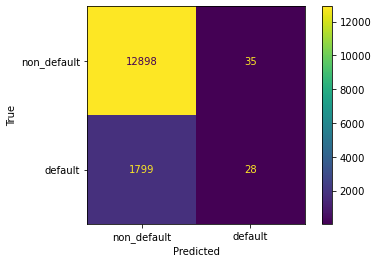

In [70]:
# построим confusion matrix
conf_mat(y_test, y_predicted)

### Модель ухудшилась.

### Попробуем применить Undersampling для получения более сбалансированной выборки.

In [75]:
R_usl = RandomUnderSampler(random_state=42)
X_usl, y_usl = R_usl.fit_resample(X, y)

In [76]:
print(X_usl.shape)
print(y_usl.shape)

(18744, 44)
(18744,)


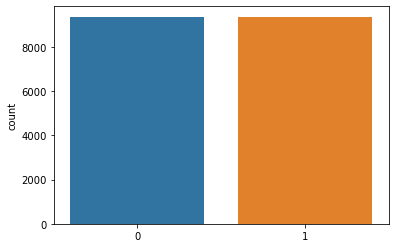

In [80]:
sns.countplot(x = y_usl)
plt.show()

In [77]:
print(X.shape)
print(y.shape)

(73799, 44)
(73799,)


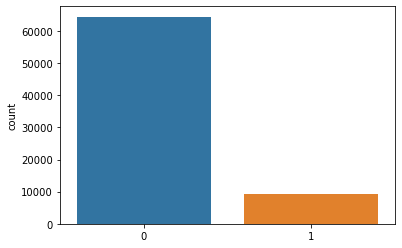

In [81]:
sns.countplot(x = y)
plt.show()

### Мы видим, что получили более сбалансированную выборку по целевому параметру
### Попробуем провести на ней обучение, используя параметы Model 3 

In [82]:
X_train_usl, X_test_usl, y_train_usl, y_test_usl = train_test_split(X_usl, y_usl, test_size=0.20, random_state=42)

In [93]:
model_usl = LogisticRegression(C = 1.0,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 300,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'lbfgs',
  tol = 0.0001,
  verbose = 0,
  warm_start = False)
model_usl.fit(X_train_usl, y_train_usl)
probs = model_usl.predict_proba(X_test_usl)
y_pred_probs_usl = probs[:,1]
y_predicted_usl = model_usl.predict(X_test_usl)

In [94]:
# посмотрим метрики
summary_metrics(summary,'Model 4_usl',y_test_usl,y_predicted_usl,y_pred_probs_usl)

,model 1,model 2,model 3,model 4,Model 4_usl,Model 5_usl
accuracy,0.874661,0.874593,0.671206,0.875745,0.674580,0.512403
precision,0.392523,0.388889,0.226401,0.444444,0.668063,0.886364
recall,0.022989,0.022989,0.685276,0.015326,0.685285,0.020945
f1_score,0.043433,0.043411,0.340356,0.029630,0.676564,0.040923
ROC_AUC,0.744526,0.744489,0.744208,0.744840,0.737139,0.737168


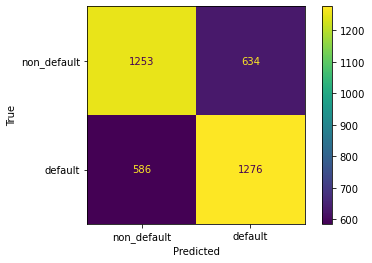

In [95]:
# построим confusion matrix
conf_mat(y_test_usl, y_predicted_usl)

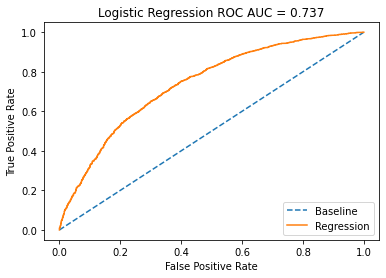

In [98]:
# построим график ROC AUC
roc_auc_curve(y_test_usl, y_pred_probs_usl)

### Модель ухудшилась на данных параметрах, попробуем провести настройки параметров

In [99]:
model_usl = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model_usl, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train_usl, y_train_usl)
model_usl = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model_usl.get_params()

print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print('  %s = %r,' % (param_name, best_parameters[param_name]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.66447137        nan
 0.66447137        nan 0.6652315  0.66496157        nan 0.66522796
 0.66522752 0.6652315  0.66496157        nan 0.66522796 0.66522752
 0.66460196 0.66442068 0.6643318  0.66455392 0.6642382  0.66460196
 0.66442068 0.6643318  0.66455392 0.6642382  0.66513705 0.6653587
 0.66513705 0.66513705 0.66513705 0.6653587  0.66513705 0.66513705
 0.66504448 0.66460067 0.66504448 0.66504448 0.66504448 0.66460067
 0.66504448 0.66504448]
  category=UserWarning


Лучшие значения параметров:
  C = 1.0,
  class_weight = 'none',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'none',
  random_state = 42,
  solver = 'lbfgs',
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Попробуем обучить модель на новых параметрах.

In [101]:
model_usl = LogisticRegression(C = 1.0,
  class_weight = 'none',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 300,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'none',
  random_state = 42,
  solver = 'lbfgs',
  tol = 0.0001,
  verbose = 0,
  warm_start = False)
model_usl.fit(X_train_usl, y_train_usl)
probs = model_usl.predict_proba(X_test_usl)
y_pred_probs_usl = probs[:,1]
y_predicted_usl = model_usl.predict(X_test_usl)

In [102]:
# посмотрим метрики
summary_metrics(summary,'Model 5_usl',y_test_usl,y_predicted_usl,y_pred_probs_usl)

,model 1,model 2,model 3,model 4,Model 4_usl,Model 5_usl
accuracy,0.874661,0.874593,0.671206,0.875745,0.674580,0.674847
precision,0.392523,0.388889,0.226401,0.444444,0.668063,0.668061
recall,0.022989,0.022989,0.685276,0.015326,0.685285,0.686359
f1_score,0.043433,0.043411,0.340356,0.029630,0.676564,0.677086
ROC_AUC,0.744526,0.744489,0.744208,0.744840,0.737139,0.737168


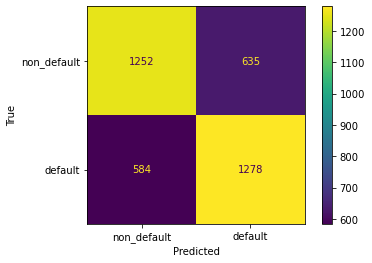

In [103]:
# построим confusion matrix
conf_mat(y_test_usl, y_predicted_usl)

### Попробуем использовать данную модель для всего набора данных

In [111]:
probs = model_usl.predict_proba(X_test)
y_pred_probs = probs[:,1]
y_predicted = model_usl.predict(X_test)

In [112]:
# посмотрим метрики
summary_metrics(summary,'Model 5_full',y_test,y_predicted,y_pred_probs)

,model 1,model 2,model 3,model 4,Model 4_usl,Model 5_usl,Model 5_full,Model final
accuracy,0.874661,0.874593,0.671206,0.875745,0.674580,0.674847,0.670867,0.671206
precision,0.392523,0.388889,0.226401,0.444444,0.668063,0.668061,0.226691,0.226401
recall,0.022989,0.022989,0.685276,0.015326,0.685285,0.686359,0.688013,0.685276
f1_score,0.043433,0.043411,0.340356,0.029630,0.676564,0.677086,0.341020,0.340356
ROC_AUC,0.744526,0.744489,0.744208,0.744840,0.737139,0.737168,0.744133,0.744208


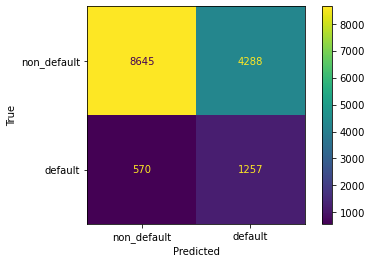

In [113]:
# построим confusion matrix
conf_mat(y_test, y_predicted)

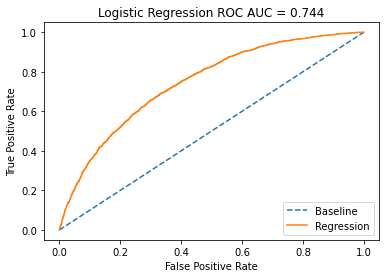

In [114]:
# построим график ROC AUC
roc_auc_curve(y_test, y_pred_probs)

In [ ]:
### Вывод - данная модель не дает существенных преимуществ по сравнению с Model 3, но все равно будем использовать её как финальный вариант.
### Делаем submission

### Вывод - данная модель не дает существенных преимуществ по сравнению с Model 3, но все равно будем использовать её как финальный вариант.
### Делаем submission

In [115]:
X_test = test_dfm.drop(['default'], axis=1)

In [124]:
y_pred_prob = model_usl.predict_proba(X_test)[:,1]

In [127]:
submit = pd.DataFrame(data_test['client_id'])
submit['default'] = y_pred_prob

In [130]:
submit.sample(10)

,client_id,default
24964,73084,0.109284
2983,94112,0.637926
28873,41797,0.627629
10578,86581,0.610039
12262,22352,0.130926
29130,56567,0.661417
2453,5720,0.423239
8208,106278,0.553590
6765,66752,0.253364
6882,19210,0.393966


In [131]:
submit.to_csv('submission.csv', index=False)